# **BIGRAM MODEL ADVANCED (3 inp --> 1 out)**

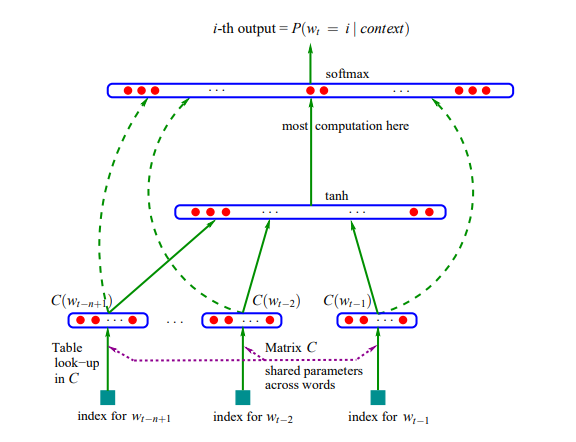

In [193]:
from IPython.display import Image
Image("language_bigram_model.png")

# This is the structure of the model we're gonna build.
# Here we feed in 3 characters as input.
# Then the 3 input is converted into Embeddings by seeing through the loop-up table.
# Then we feed in these input to the hidden layers.
# Then the output of the hidden layer is then tanh'ed and send to output layer.
# Then the output of the output layer is then softmax'ed and converted into probability distribution.
# Using the probability we can find the next character.
# So this is basically a model which takes in 3 character and outputs 1 character.

### Importing Dependencies

In [194]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the names for Training

In [195]:
names = open('names.txt','r').read().splitlines()
print(f'Total names in the training set: {len(names)}')
print(f'First 8 Names: {names[:8]}')

Total names in the training set: 32033
First 8 Names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


### Creating dictionaries for Character <---> Integer conversion

In [196]:
chars = sorted(list(set(''.join(names)))) # Creating a set of all possible characters from the training set, and storing it in a list by sorting them.
stoi = {s:i+1 for i,s in enumerate(chars)} # Dictionary to convert characters to integers.
stoi['.'] = 0 # We assign . integer value to zero for convinience.
itos = {i:s for s,i in stoi.items()} # Dictionary to convert integers to characters.

### Building Dataset for First 5 Names

In [ ]:
# build the dataset
block_size = 3 # Context Length: How many characters do we take to predict the next one?
X, Y = [], []
for name in names[:5]:
    
    print(name)
    context = [0] * block_size # Starting from ... to predict the next character.

    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
    
    print()

X = torch.tensor(X) # Training tensor
Y = torch.tensor(Y) # Validation tensor

# X.shape --> [32,3] --> Now lets take 32 examples where each input is of size 3.

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

torch.Size([32, 3]) torch.int64 torch.Size([32]) torch.int64


##### Notes on embedding matrix & view()

In [ ]:
# 1. C[5]                                                       | ---> Retrieve Embeddings for 'e'.  
# 2. F.one_hot(torch.tensor(5), num_classes=27).float() @ C     | ---> Just another way of doing that But, since Indexing is faster we gonna use that. 

# C --> LOOK-UP TABLE
# If we need to convert this row to its corresponding embeddings, we need to index every element of this X's row through C.
# For example: 
#       C is the look-up tensor Table of dimension [27,2].
#       X is the Training Set which has the datas of first 5 names.
#       X's Dimension is [32, 3] where 3 is the context size.
#       X[10,:] ---> tensor([ 9, 22,  9]) --> This tensor is coming from the word olivia and the corresponding characters: ivi
#       Now we need to convert this X[10,:] to its corresponding embeddings. Pytorch Indexing is powerful.
#       C[X][10,:] --> This will convert the corresponding row of X to its embeddings. We dont need to feed every single character to C and get the embedding.
#       Now C[X][10,:] ---> tensor([[ 0.3881,  1.2356], ---> Embedding of 'i'.
#                                   [-0.6346,  0.0094], ---> Embedding of 'v'.
#                                   [ 0.3881,  1.2356]]) --> Embedding of 'i'.
#       So if we find the embeddings for all the values of X, then the resultant Embedding Tensor's Dimension will be [32, 3, 2].

# After Embeddings creation we need to pass it to hidden layer of 100 neurons.
# There are 3 characters we're gonna pass it to hidden layer. So each embeddings of a single character is a tensor of Dimension [2].
# So passing 3 will result in 6 inputs, that is in tensor its a dimension of [3,6].
# Now if we create a Hidden Layer with 100 neurons, then each neuron will take 18 inputs.
# So Constructing weights and biases for a single neuron here is by this command:
#       W1 = torch.randn((18, 100))
#       b1 = torch.rand(100)
# SO our embedding will be emb = C[X]
# But to calculate the weighted sum (emb @ W + b) its not possible because, emb --> [32, 3, 2] and W --> [6, 100].
# So we need to convert this emb --> [32, 3, 2] to emb --> [32, 6].
# We need to use torch.cat() (concatenate) to make this to [32, 6].
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) --> here the 1 is concatinating by squeeshing columns (Row concatenation).
# Above method is inefficient because, if context (block) size changes then it doesn't work because of hardcoding.
# For resolving the above, it can also be done using torch.cat(torch.unbind(emb, 1), 1).
# Above what happens:
#       unbind removes the dimension 3 in [32, 3, 2] because 1 (1 is the index of 3 in [32, 3, 2]) is passed to it. 
#       Then Now we will have three [2] dimension tensor.
#       Then Normal conactenation by squeeshing columns results [6] dimension tensor.
#       Now the end result will be [32, 6]. 
# Doing this above steps to all examples will result in emb ---> [32, 6].
# But more effieciently we can do this by: emb.view(32, 6). Now this will convert emb to [32, 6]. Not that 6 should be the result of the multiplication of the dimensions, you cant add your own values.
# view() will not create any extra memory when used. Because, it just manipulates the view (by manipulating the view attributes) form the storage (In storage a tensor is stored in a 1D format irresprctive of its dimensions).
# torch.cat() will create a whole new tensor with a whole new storage because there is no way we concatenate tensors just by manipulating the view attributes.

### Embeddings Matrix, Weights & Biases, Inputs to Embeddings, Forward pass, Current Loss

In [254]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility

# Embedding Matrix (Look-Up Table)
C = torch.randn((27,2), generator=g) # Here we're gonna Create a look-up table for Embedding conversion.
                                     # Just for our understanding, all 27 character embeddings here will be of dimension 2.

# Hidden Layer
W1 = torch.randn((6, 100), generator=g) # We gonna create a hidden layer of 100 neurons where each neuron takes 6 inputs.
b1 = torch.rand(100, generator=g) # For 100 neurons there are 100 bias.

#Output layer
W2 = torch.randn((100, 27), generator=g) # We gonna create a output layer of 27 neurons (because we have 27 character to predict next) where each neuron takes 100 inputs.
b2 = torch.rand(27, generator=g) # For 27 neurons there are 27 bias.

# Parameters
parameters = [C, W1, b1, W2, b2] # All the Parameters of the Neural Net for easy access.

for p in parameters:
    p.requires_grad = True # We need gradient (requires_grad = True), for all the parameters for backward pass.

print(f'No of parameters in total: {sum(p.nelement() for p in parameters)}') # number of parameters in total

# Creating Embeddings
emb = C[X] # Creating the Embeddings for all the examples. emb.shape ---> [32, 3, 2].


h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # Feeding the inputs to the hidden layer and got outputs from the hidden layer specified in our model.
                                            # -1 can be used in the place of emb.shape[0]. It automatically identifies -1 as number as 32 rows.
                                            # [32, 6] * [6, 100] ---> [32, 100]
logits = h @ W2 + b2    # Outputs of Output layer.
                        # Log-counts. [32, 100] * [100, 27] ---> [32, 27]
counts = logits.exp()   # Calculting counts.
prob = counts / counts.sum(1, keepdims=True) # Finding the probability distribution.
loss = -prob[torch.arange(32), Y].log().mean() # Finding the loss
print(f'Loss:  {loss.item()}')

No of parameters in total: 3481
Loss:  17.537330627441406


### Forward pass using cross_entropy

In [255]:
#  ---------- FORWARD PASS ----------
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
print(f'Loss:  {loss.item()}')

Loss:  17.537330627441406


##### Notes on cross_entropy

In [ ]:
# The line F.cross_entropy(logits, Y) is equivalent to these lines below:
#    counts = logits.exp()
#    prob = counts / counts.sum(1, keepdim=True)
#    loss = -prob[torch.arange(32), Y].log().mean()

# Advantages of using cross_entropy:
# 1 --> cross_entropy will not actually create all these intermediate tensors (which take extra storage) which is fairly inefficient to run. 
#       So pytorch will cluster up all these operations and very often create have fused kernels that are very efficiently evaluate these expressions that are sort of like clustered mathematical operations.
# 2 --> The backward pass can be made much more efficient and not just because it's a fused kernel but also analytically and mathematically it's much often a very much simpler backward pass to implement.
#       so there's much less to implement so not only can it be made more efficient because it runs in a fused kernel but also because the expressions can take a much simpler form mathematically.
#       For example in micrograd's tanh function's expression (t = (math.exp(2*x)-1)/(math.exp(2*x)+1)) is something comlicated right but, we dont use this exact equation to find the derivative.
#       Instead we use antoher simpler equation for finding the derivative (self.grad += (1 - t**2) * out.grad) (here we reuse the value t).
#       Here the derivative is simpler, which makes the bacward pass simpler to implement. 
# 3 --> For example: 
#           If the logits ---> tensor([-2, -3, 0, 5])
            # counts = logits.exp()
            # probs = counts / counts.sum(1, keepdim=True)
            # probs = tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])
            # This will normally give a proper probability distribution.

            # If the logits ---> tensor([-100, -3, 0, 5])
            # probs = tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])
            # because exponentiating a large negative number will result in a value between [0,1]. 

            # If the logits ---> tensor([-100, -3, 0, 100])
            # probs = tensor([0., 0., 0., nan])
            # because exponentiating a large positive number will result in a value the moves towards infinity. 
            # So here nan (not a number) is returned because counts is tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,inf])

            # To resolve this we need to find the largest number in the logits and subract it from the logits. 
            # Dont worry this will not affect the porbability distribution because we're subracting the largest number with every element of the logits.

            # If the logits ---> torch.tensor([-100, -3, 0, 100]) - 100
            # tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])
        # But all these steps we saw here are resolved by the user which is inefficient.
        # But cross Entropy will automatically subract the largest number in the logits from the logits tensor.

tensor(17.7697)

### Loss after Backward Pass

In [252]:
#  ---------- BACKWARD PASS ----------
for p in parameters:
    p.grad = None
loss.backward()

# Tweaking Weights
for p in parameters:
    p.data += -0.1 *  p.grad # here 0.1 is the learning rate.

#  ---------- FORWARD PASS ----------
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
print(f'Loss:  {loss.item()}')

Loss:  15.695512771606445


##### Notes on Overfitting

In [ ]:
# Overfitting a single batch of data because we only use 32 examples.
# Here the loss very close to zero because we are training only with 32 examples with a neural network of many parameters.
# This is why we are very close to zero. But why can't we hit zero. That is if we hit zero then the model will exactly remember every possible unique combinations and its outpus.
# That is where the twist comes. So when we create the data set that is 
                # ... ---> e
                # ..e ---> m
                # .em ---> m
                # emm ---> a
                # mma ---> .

                # olivia
                # ... ---> o
                # ..o ---> l
                # .ol ---> i
                # oli ---> v
                # liv ---> i
                # ivi ---> a
                # via ---> .

                # ava
                # ... ---> a
                # ..a ---> v
                # .av ---> a
                # ava ---> .

                # isabella
                # ... ---> i
                # ..i ---> s
                # ...
                # oph ---> i
                # phi ---> a
                # hia ---> .

# Here for every combinations the outputs are unique expect for one combination that for this combination(...).
# This ... may predict the next value to be any of these (e,o,a,i) in this training set.
# Here you can see:

# print(logits.max(1))
#     Logits = ttorch.return_types.max(
#   values=tensor([12.8570, 15.2782, 18.0706, 19.8688, 16.5893, 12.8570, 17.0453, 15.6529,
#         16.9717, 18.9867, 16.1031, 15.3543, 12.8570, 17.1609, 12.4340, 16.0421,
#         12.8570, 16.9594, 15.9623, 13.1808, 12.0324, 16.5974, 18.4181, 17.4922,
#         15.6558, 12.8570, 15.9989, 15.2950, 19.5289, 16.5407, 15.0322, 15.0557],
#        grad_fn=<MaxBackward0>),
#   indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
#          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

# print(Y)
# tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
#          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Here you can see the Y is the desired output and most of the logits are same that to Y, except for some values, This shows that our model is prediciting excatly what it saw in its training set.
# But some logits are different because of the reason I stated above.
# if these combination were unique we can make the model's loss zero.

### Overfitting

In [256]:
for _ in range(1000): # Ran in this order: 10 100 1000
    #  ---------- FORWARD PASS ----------
    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
    logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    # Tweaking Weights
    for p in parameters:
        p.data += -0.1 *  p.grad # here 0.1 is the learning rate.
print(loss.item())

0.2557545602321625


# **Understanding the use of Mini-Batches**

### Building Dataset for all Names

In [267]:
# build the dataset
block_size = 3 # Context Length: How many characters do we take to predict the next one?
X, Y = [], []
for name in names:

    context = [0] * block_size

    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

# X.shape, Y.shape ---> (torch.Size([228146, 3]), torch.Size([228146]))

### Weights & Biases

In [272]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}') # number of parameters in total

Total Parameters: 3481


### Training Model using all Names

In [269]:
for _ in range(20):
    #  ---------- FORWARD PASS ----------
    emb = C[X] # [228145, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [228145, 6] * [6, 100] ---> [228145, 100]
    logits = h @ W2 + b2 # [228145, 100] * [100, 27] ---> [228145, 27]
    loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
    print(loss.item())

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    # Tweaking Weights
    for p in parameters:
        p.data += -0.1 *  p.grad # here 0.1 is the learning rate.

19.505226135253906
17.084495544433594
15.776533126831055
14.833344459533691
14.002609252929688
13.253265380859375
12.57992172241211
11.98310661315918
11.470500946044922
11.051864624023438
10.709595680236816
10.407641410827637
10.12781810760498
9.864374160766602
9.614513397216797
9.376448631286621
9.148953437805176
8.931118965148926
8.722238540649414
8.521757125854492


##### Notes on mini batch

In [ ]:

# You can notice the delay your system experience before finding a loss.
# This is because when we backward pass here we going through all names examples.
# So this will take some time, than 5 Example names.
# But you can see that the loss decreases very little & slowly.

# To resolve this we use Mini Batch:
# Without using mini batches the backward pass take a little time because it has to deal with all the examples we feed in.
# Using mini batches should be much much faster and instant almost.
# So this way we can run many many examples nearly instantly and decrease the loss much much faster now, because we're only dealing with mini batches.
# The quality of our gradient is lower so the direction is not as reliable than that of the actual gradient direction.
# But the gradient direction is good enough even when it's estimating on only 32 examples that it is useful.
# So it's much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient and take fewer steps.

### Training Model using Mini-Batches

In [273]:
# This uses mini batch so provcessing it would be much faster.
# Re-Initialize the weight and see the difference from without using Mini-Batches

for _ in range(100):
    
    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
    logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    # Tweaking Weights
    for p in parameters:
        p.data += -0.1 *  p.grad # here 0.1 is the learning rate.

    # Actual loss of the Model
    emb = C[X] # [228145, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [228145, 6] * [6, 100] ---> [228145, 100]
    logits = h @ W2 + b2 # [228145, 100] * [100, 27] ---> [228145, 27]
    loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
    print(loss.item())

17.034412384033203
15.934038162231445
14.95693302154541
13.896039962768555
13.091625213623047
12.398204803466797
11.763871192932129
11.370072364807129
10.964266777038574
10.759404182434082
10.526002883911133
10.20949935913086
10.03164291381836
9.78310775756836
9.599995613098145
9.379416465759277
9.200411796569824
8.99071216583252
8.763954162597656
8.618619918823242
8.497174263000488
8.30810832977295
8.138728141784668
8.012813568115234
7.863033771514893
7.777397155761719
7.5881524085998535
7.541803359985352
7.434265613555908
7.246087074279785
7.050011157989502
6.954770565032959
6.8603291511535645
6.718832015991211
6.606995582580566
6.5541839599609375
6.4412102699279785
6.339524269104004
6.263597011566162
6.156391620635986
6.072021484375
5.99855375289917
5.9886698722839355
5.914994716644287
5.834670543670654
5.764225006103516
5.653184413909912
5.602034091949463
5.566293239593506
5.554244518280029
5.42633056640625
5.37190055847168
5.324639797210693
5.267823696136475
5.240894317626953
5.19

# **Finding Good initial Learning Rate**

### Building Dataset for all Names

In [287]:
# build the dataset
block_size = 3 # Context Length: How many characters do we take to predict the next one?
X, Y = [], []
for name in names:

    context = [0] * block_size

    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

# X.shape, Y.shape ---> (torch.Size([228146, 3]), torch.Size([228146]))

### Weights & Biases

In [288]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}') # number of parameters in total

Total Parameters: 3481


### Learning Rates & Exponents

In [289]:
# lre = torch.linspace(0.0001, 1, 1000)
lre = torch.linspace(-3, 0, 1000) # learning rate exponent this is equivalent -3 --> 10 ** -3 = 0.0001 and 0 --> 10 ** 0 = 1, created 1000 values in between those.
lrs = 10**lre # actual learning rate

### Learning Exponent & Loss Visualization

In [290]:
lri =[]
lossi = []

for i in range(1000):
    
    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
    logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i]
    # Now you can set the lr = 10**-1 or lr = 0.1

    # Tweaking Weights
    for p in parameters:
        p.data += -lr *  p.grad # here 0.1 is the learning rate.

    # Track Stats
    lri.append(lre[i]) # Not the actual learning rate but the exponent of lr. 
    lossi.append(loss.item())

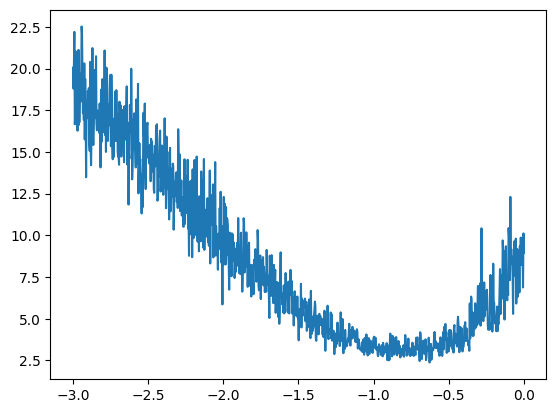

In [291]:
plt.plot(lri, lossi) # Create a Visualization for what learning rate exponent, the loss is less. 
                     # We got to know -1 results in low loss.
                     # So by 10 ** -1 --> 0.1
                     # So the learning rate --> 0.1 is best. 

### Traning After Finding Best Learning Rate

In [ ]:
for i in range(1000):
    
    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
    logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 # So the learning rate --> 0.1 is best according to the graph.

    # Tweaking Weights
    for p in parameters:
        p.data += -lr *  p.grad # here 0.1 is the learning rate.

# Actual loss of the Model
emb = C[X] # [228145, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [228145, 6] * [6, 100] ---> [228145, 100]
logits = h @ W2 + b2 # [228145, 100] * [100, 27] ---> [228145, 27]
loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
print(loss.item())

2.6098477840423584


##### Notes on training, validation & test set

In [ ]:
# when the capacity (No of parameters) becomes more, then the model becomes more and more capable of overfitting your training set.
# That means that the loss on the training set on the data that you're training on will become very very low as low as zero.
# But all that the model is doing is memorizing your training set, so if you take that model and it looks like its working perfectly really well.
# But if you try to sample from it, you will basically only getr examples exactly as they are in the training set. you wont get any new data.
# In addition to that if you try to evaluate the loss on some other names or words, you will actually see that the loss on those can be very high.
# So basically its not a good model.
# So the standard in the filed is to split up your data set into three splits as we call them, training split (train parameteres), dev/validation split (train hyperparameteres), and the test split (evaluate performance of the model).
# That should be 80%, 10% and 10% of your dataset roughly.
# so we're only evaluating the loss on the test plate very very sparingly and very
# few times because every single time you evaluate your test loss and you learn something from it
# you are basically starting to also train on the test split so you are only allowed to test the loss
# on a test set very very few times otherwise you risk
# overfitting to it as well as you experiment on your model so let's also split up our training data

# **TRAIN, VAL, TEST**

In [293]:
# build the dataset
def build_dataset(names):
    block_size = 3 # Context Length: How many characters do we take to predict the next one?
    X, Y = [], []
    for name in names:
        
        context = [0] * block_size

        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names)) # 80% percent
n2 = int(0.9*len(names)) # 90% percent

Xtr, Ytr = build_dataset(names[:n1]) # 80% percent of training set.
Xdev, Ydev = build_dataset(names[n1: n2]) # 10% (90 - 80) percent of validation set.
Xte, Yte = build_dataset(names[n2:]) # 10% (100 - 90) percent of test set.

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### Weights & Biases

In [297]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}') # number of parameters in total

Total Parameters: 3481


### Training Model

In [ ]:
for i in range(30000):

    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 100] ---> [32, 100]
    logits = h @ W2 + b2 # [32, 100] * [100, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 # So the learning rate --> 0.1 is best according to the graph.

    # Tweaking Weights
    for p in parameters:
        p.data += -lr *  p.grad # here 0.1 is the learning rate.

print(loss.item())

### Loss on training Data

In [ ]:
emb = C[X] # [228145, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [228145, 6] * [6, 100] ---> [228145, 100]
logits = h @ W2 + b2 # [228145, 100] * [100, 27] ---> [228145, 27]
loss = F.cross_entropy(logits, Y) # Best efficient way to calculate loss
print(loss.item())

### Loss on Validation Data

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # Best efficient way to calculate loss
print(loss.item())

2.331393003463745


In [ ]:
# This model is not powerful enough to purely overfit.
# We are underfitting, Because the training loss and the validation loss are roughly equal.
# This means that our network is very tiny, we expect to make performance improvements by scaling up this neural net 

# **SCALING UP NEURAL NETWORK**

### Weights & Biases

In [308]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # 300 neurons
b1 = torch.randn(300, generator=g) # 300 biases
W2 = torch.randn((300, 27), generator=g) 
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}') # number of parameters in total

Total Parameters: 10281


### Visualization

In [ ]:
lri = []
lossi = []
stepi = []


for i in range(30000):
    
    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 6] * [6, 300] ---> [32, 300]
    logits = h @ W2 + b2 # [32, 300] * [300, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 # So the learning rate --> 0.1 is best according to the graph.

    # Tweaking Weights
    for p in parameters:
        p.data += -lr *  p.grad # here 0.1 is the learning rate.

    # Track Stats
    # lri.append(lre[i]) # Not the actual learning rate but the exponent of lr. 
    stepi.append(i)
    lossi.append(loss.item())

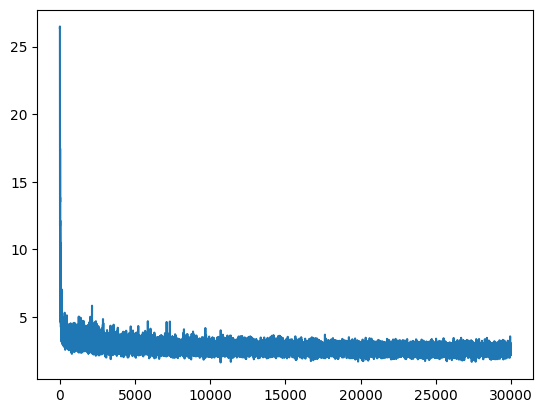

In [310]:
plt.plot(stepi, lossi)

### Loss on training Data

In [ ]:
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 300]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ytr) # Best efficient way to calculate loss
print(loss.item())

2.5951967239379883


### Loss on Validation Data

In [ ]:
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 300]
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Ydev) # Best efficient way to calculate loss
print(loss.item())

2.5946311950683594


In [313]:
# We are not improving because we use the embedding vector dimesions 2 and its like cramming way too much characters into just 2 dimensions.
# ANd Neural net is not able to really use that space effectively.
# Now lets visualize the embedding vector for these characters before we scale up the ebedding size from 2.
# We are visualizing now because we cant when we scale up. 

### Embedding Matrix Visualization

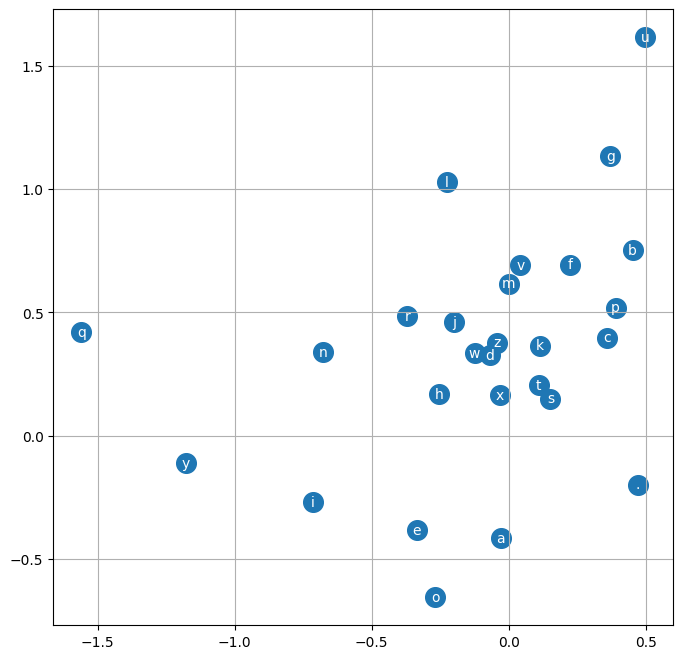

In [148]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# **SCALING THE EMBEDDING**

### Weights & Biases

In [321]:
g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((27, 10), generator=g) # embedding size 10
W1 = torch.randn((30, 200), generator=g) # 30 input for each neuron, 200 neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [322]:
lri =[]
lossi1 = []
lossi2 = []
stepi = []

In [ ]:
for i in range(50000):
    
    # Mini-Batch construct 
    ix = torch.randint(0, X.shape[0], (32,)) # This will create 32 random variable (index) from [0, 228146].

    #  ---------- FORWARD PASS ----------
    emb = C[X[ix]] # [32, 3, 10]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32, 30] * [30, 200] ---> [32, 200]
    logits = h @ W2 + b2 # [32, 200] * [200, 27] ---> [32, 27]
    loss = F.cross_entropy(logits, Y[ix]) # Here Loss is just for 32 examples.

    #  ---------- BACKWARD PASS ----------
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 # So the learning rate --> 0.1 is best according to the graph.

    # Tweaking Weights
    for p in parameters:
        p.data += -lr *  p.grad # here 0.1 is the learning rate.

    # Track Stats
    # lri.append(lre[i]) # Not the actual learning rate but the exponent of lr. 
    stepi.append(i)

    lossi1.append(loss.item())
    lossi2.append(loss.log10().item())

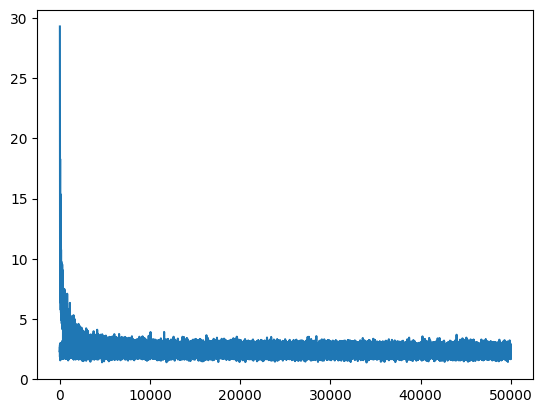

In [334]:
plt.plot(stepi, lossi1) # plotting loss instead of log loss.

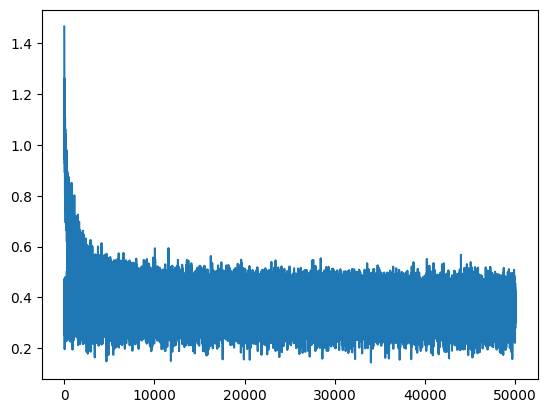

In [335]:
plt.plot(stepi, lossi2) # plotting log loss instead of loss just for squashing the diagram.
                        # its still thick because of the mini batch size.

### Loss on training Data

In [340]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) # Best efficient way to calculate loss
print(loss.item())

2.2432069778442383


### Loss on Validation Data

In [341]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # Best efficient way to calculate loss
print(loss.item())

2.2458877563476562


# **SAMPLING**

In [342]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


chriah.
qui.
herithimritheoty.
skandon.
jurinton.
perrit.
kaeli.
nekonia.
chaiivon.
leggph.
lug.
dis.
quinnis.
lis.
alianni.
waleigh.
jarixi.
frani.
dustine.
deci.


In [343]:
# i think surpass this number so number one you can of course change
# the number of neurons in the hidden layer of this model you can change the dimensionality of the embedding
# lookup table you can change the number of characters that are feeding in as an input
# as the context into this model and then of course you can change the details of the optimization how long are
# we running what is the learning rate how does it change over time how does it decay
# you can change the batch size and you may be able to actually achieve a much better convergence speed
# in terms of how many seconds or minutes it takes to train the model and get
# your result in terms of really good loss 